In [1]:
#A dependency of the preprocessing for BERT inputs
#!pip install "tensorflow==2.11.*"
#!pip install -q -U "tensorflow-text==2.11.*"
#!pip install -q _U "tf-models-official==2.11.*"
#!pip install  -q -U tensorflow-hub
!pip install tensorflow
!pip install tensorflow-hub
!pip install tensorflow-text
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
   

In [2]:
#Importing the pandas library for reading
import pandas as pd

In [3]:
#Importing the numpy, matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Importing sklearn, tensorflow, keras libraries for model implementation
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers

from official.nlp import optimization # to create AdamW optimizer
#from keras.optimizers import optimizer # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')


In [5]:
from subprocess import check_output
print(check_output(["ls", "../input/final-cleansed-14042023"]).decode("utf8"))

final-dataset.csv



In [6]:
#Read the input data
train_path = '../input/final-cleansed-14042023/final-dataset.csv'
df_train = pd.read_csv(train_path)

#Checking the info of the dataset
df_train.info

<bound method DataFrame.info of                                              comment_text  severe_toxicity  \
0       OH yes - Were those evil Christian Missionarie...                0   
1       Why is this black racist crap still on the G&M...                0   
2                              even up here.......BLACKS!                0   
3       Blame men.  There's always an excuse to blame ...                0   
4       And the woman exposing herself saying grab thi...                0   
...                                                   ...              ...   
446846  Another man shamming article. If white men did...                0   
446847  "no matter what is put in front of you regardi...                0   
446848  The Democrat party aided and abetted by it's M...                0   
446849  I just don't find her a very good representati...                0   
446850  You know the Trump fanatics are trolling the G...                0   

        obscene  sexual_explici

In [7]:
#df_train.fillna(0, inplace=True)
df_train.dropna(inplace=True)
#df_train.head()
df_train.count()

comment_text              446596
severe_toxicity           446596
obscene                   446596
sexual_explicit           446596
identity_attack           446596
insult                    446596
threat                    446596
other                     446596
gender                    446596
religion                  446596
race                      446596
disability                446596
Target                    446596
processed_comment_text    446596
comment_text_processed    446596
dtype: int64

In [8]:
#@title Choose a BERT model to fine-tune

#bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
#bert_model_name = 'small_bert/bert_en_uncased_L-6_H-768_A-12'
#bert_model_name = 'small_bert/bert_en_uncased_L-4_H-768_A-12'
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'


map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [9]:
#defining the model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

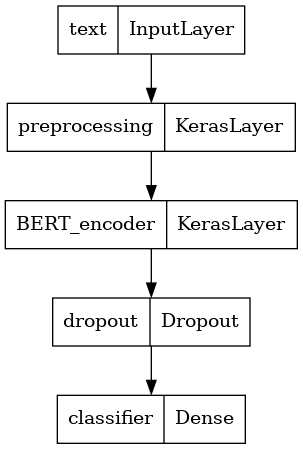

In [11]:
#model architecture
tf.keras.utils.plot_model(classifier_model)

In [12]:
#Loss Function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [13]:
#Optimization
epochs = 3
steps_per_epoch = 9800 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
#3.5e-6
#2e−5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [14]:
#Compile Model
classifier_model.compile(optimizer=optimizer, loss=loss,
                         metrics=metrics)

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [15]:
# Balancing the dataset by undersampling from the majority class
# df_train_1 = df_train[df_train['Target']== 1]
# df_train_0 = df_train[df_train['Target']== 0]
# df_train_0_downsampled = df_train_0.sample(df_train_1.shape[0])
# df_balanced = pd.concat([df_train_0_downsampled, df_train_1])
# df_balanced['Target'].value_counts()

In [16]:
#Balancing the dataset by oversampling from the minority class
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

#fit predictor and target variable
x_balanced, y_balanced = ros.fit_resample(df_train[['comment_text']], df_train[['Target']])

print('Original dataset shape', df_train['Target'].value_counts())
print('Resample dataset shape', y_balanced.value_counts())

Original dataset shape 0    395808
1     50788
Name: Target, dtype: int64
Resample dataset shape Target
0         395808
1         395808
dtype: int64


In [17]:
# Split the DataFrame into a text array and a label array
# df_train_x = df_train[['comment_text']]

#Undersampling
# df_train_x = df_balanced[['comment_text_processed']]
# df_train_y = df_balanced[['Target']]

#Oversampling
df_train_x = x_balanced
df_train_y = y_balanced

#train val split
x_train, x_testval, y_train, y_testval = train_test_split(df_train_x, df_train_y, 
                                                  test_size = 0.2, shuffle = True)

#val test split
x_val, x_test, y_val, y_test = train_test_split(x_testval, y_testval, 
                                                  test_size = 0.5, shuffle = True)

print('Shape of Training Matrix:'+str(x_train.shape))
print('Shape of Training Target:'+str(y_train.shape))
print('Shape of Validation Matrix:'+str(x_val.shape))
print('Shape of Validation Target:'+str(y_val.shape))
print('Shape of Testing Matrix:'+str(x_test.shape))
print('Shape of Testing Target:'+str(y_test.shape))

Shape of Training Matrix:(633292, 1)
Shape of Training Target:(633292, 1)
Shape of Validation Matrix:(79162, 1)
Shape of Validation Target:(79162, 1)
Shape of Testing Matrix:(79162, 1)
Shape of Testing Target:(79162, 1)


In [18]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633292 entries, 115854 to 106085
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Target  633292 non-null  int64
dtypes: int64(1)
memory usage: 9.7 MB


In [19]:
#training the model
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = x_train, y = y_train,
                               validation_data = (x_val, y_val),
                               epochs = epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Epoch 1/3
19791/19791 [==============================] - 11611s 586ms/step - loss: 0.2638 - binary_accuracy: 0.8859 - val_loss: 0.1595 - val_binary_accuracy: 0.9480
Epoch 2/3
19791/19791 [==============================] - 11599s 586ms/step - loss: 0.1094 - binary_accuracy: 0.9655 - val_loss: 0.1592 - val_binary_accuracy: 0.9544
Epoch 3/3
19791/19791 [==============================] - 11544s 583ms/step - loss: 0.0920 - binary_accuracy: 0.9716 - val_loss: 0.1592 - val_binary_accuracy: 0.9544


In [20]:
#Evaluate the model
#df_test_x = df_test[['comment_text']]
y_pred = classifier_model.predict(x = x_test)

2474/2474 [==============================] - 531s 214ms/step


In [21]:
#predicted values
y_pred = np.where(y_pred < 0.5 , 0, 1)
y_pred.shape

print('y = 0 -> ', np.count_nonzero(y_pred == 0))
print('y = 1 -> ', np.count_nonzero(y_pred == 1))

y = 0 ->  36708
y = 1 ->  42454


In [22]:
#evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.9551173542861474
Precision: 0.9222452536863429
Recall: 0.9936048724781119
F1 score: 0.9565960981688025


In [23]:
# loading library
import pickle

# create an iterator object with write permission - smallbert_v3
with open('smallbert_v3', 'wb') as files:
    pickle.dump(classifier_model, files)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......input_layer
.........vars
......keras_layer
.........vars
......keras_layer_1
.........vars
............0
............1
............10
............100
............101
............102
............103
............104
............105
............106
............107
............108
............109
............11
............110
............111
............112
............113
............114
............115
............116
............117
............118
............119
............12
............120
............121
............122
............123
............124
............125
............126
............127
............128
............129
............13
............130
............131
............132
............133
............134
............135
............136
............137
............138
............139
............14
.